# Sentiment Classification Model 1

 Trained on IMDB dataset, predicts on WW2 Bunker Reviews

### 1. Import Dependencies

In [3]:
import pandas as pd
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from transformers import (
    BertTokenizer, 
    BertForSequenceClassification, 
    Trainer, 
    TrainingArguments
)
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_recall_fscore_support





### 2. Load Data

In [2]:
df = pd.read_pickle("../data/processed/processed_movie_reviews.pkl")
df.head()

,review,sentiment,clean_text,tokens
0,One of the other reviewers has mentioned that ...,1,One of the other reviewers has mentioned that ...,"{'input_ids': [101, 2028, 1997, 1996, 2060, 15..."
1,A wonderful little production. <br /><br />The...,1,A wonderful little production. The filming tec...,"{'input_ids': [101, 1037, 6919, 2210, 2537, 10..."
2,I thought this was a wonderful way to spend ti...,1,I thought this was a wonderful way to spend ti...,"{'input_ids': [101, 1045, 2245, 2023, 2001, 10..."
3,Basically there's a family where a little boy ...,0,Basically there's a family where a little boy ...,"{'input_ids': [101, 10468, 2045, 1005, 1055, 1..."
4,"Petter Mattei's ""Love in the Time of Money"" is...",1,Petter Mattei's Love in the Time of Money is a...,"{'input_ids': [101, 9004, 3334, 4717, 7416, 10..."


### 3. Prepare Train/Validation Splits

In [ ]:
train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    df["review"], df["sentiment"], test_size=0.4, random_state=42, stratify=df["sentiment"]
)
val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts, temp_labels, test_size=0.5, random_state=42, stratify=temp_labels
)

print("Training samples:", len(train_texts))
print("Validation samples:", len(val_texts))
print("Test samples:", len(test_texts))

### 4. Create a Dataset Class

In [ ]:
class SentimentDataset(torch.utils.data.Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=512):
        # texts and labels can be lists or pd.Series
        self.texts = texts.tolist() if hasattr(texts, "tolist") else texts
        self.labels = labels.tolist() if hasattr(labels, "tolist") else labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=self.max_length,
            return_tensors="pt"
        )
        return {
            "input_ids": encoding["input_ids"].squeeze(),
            "attention_mask": encoding["attention_mask"].squeeze(),
            "labels": torch.tensor(label, dtype=torch.long)
        }

### 5. Instansiate Tokenizer & Dataset

In [ ]:
# Tokenizer for the uncased model
tokenizer_uncased = BertTokenizer.from_pretrained("bert-base-uncased")
# Tokenizer for the cased model
tokenizer_cased = BertTokenizer.from_pretrained("bert-base-cased")

# Create datasets for each tokenizer.
train_dataset_uncased = SentimentDataset(train_texts, train_labels, tokenizer_uncased)
val_dataset_uncased = SentimentDataset(val_texts, val_labels, tokenizer_uncased)
test_dataset_uncased = SentimentDataset(test_texts, test_labels, tokenizer_uncased)

train_dataset_cased = SentimentDataset(train_texts, train_labels, tokenizer_cased)
val_dataset_cased = SentimentDataset(val_texts, val_labels, tokenizer_cased)
test_dataset_cased = SentimentDataset(test_texts, test_labels, tokenizer_cased)

### 6. Initialize Model and Trainer

In [ ]:
training_args_uncased = TrainingArguments(
    output_dir="outputs_uncased",
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_dir="logs_uncased",
    logging_steps=50,
    bf16=True if torch.backends.mps.is_available() else False
)

training_args_cased = TrainingArguments(
    output_dir="outputs_cased",
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_dir="logs_cased",
    logging_steps=50,
    bf16=True if torch.backends.mps.is_available() else False
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/homebrew/lib/python3.13/site-packages/transformers/training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


### 7. Train

In [ ]:
model_uncased = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
model_cased = BertForSequenceClassification.from_pretrained("bert-base-cased", num_labels=2)

Epoch,Training Loss,Validation Loss
1,0.341300,0.318957
2,0.241700,0.406862
3,0.156900,0.512193


TrainOutput(global_step=15000, training_loss=0.25446832716464995, metrics={'train_runtime': 12589.0238, 'train_samples_per_second': 9.532, 'train_steps_per_second': 1.192, 'total_flos': 7893331660800000.0, 'train_loss': 0.25446832716464995, 'epoch': 3.0})

In [ ]:
trainer_uncased = Trainer(
    model=model_uncased,
    args=training_args_uncased,
    train_dataset=train_dataset_uncased,
    eval_dataset=val_dataset_uncased
)

trainer_cased = Trainer(
    model=model_cased,
    args=training_args_cased,
    train_dataset=train_dataset_cased,
    eval_dataset=val_dataset_cased
)

In [ ]:
print("Training bert-base-uncased model...")
trainer_uncased.train()

print("Training bert-base-cased model...")
trainer_cased.train()


### Performance on Validation Set

In [ ]:
eval_results_uncased = trainer_uncased.evaluate(test_dataset_uncased)
eval_results_cased = trainer_cased.evaluate(test_dataset_cased)

print("BERT-base-uncased test results:")
print(eval_results_uncased)

print("BERT-base-cased test results:")
print(eval_results_cased)

Accuracy:   0.8991
Precision:  0.8970
Recall:     0.9036
F1:         0.9002


### Compare the two models

[[4438  523]
 [ 486 4553]]


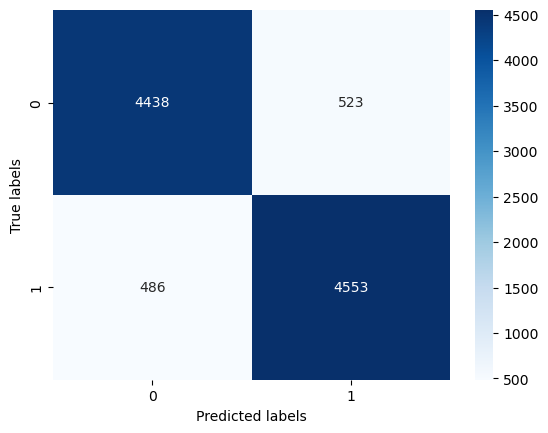

In [ ]:
preds_uncased = trainer_uncased.predict(test_dataset_uncased)
logits_uncased = preds_uncased.predictions
pred_labels_uncased = np.argmax(logits_uncased, axis=1)

from sklearn.metrics import classification_report, confusion_matrix

print("Classification Report for bert-base-uncased:")
print(classification_report(test_labels, pred_labels_uncased))

print("Confusion Matrix for bert-base-uncased:")
print(confusion_matrix(test_labels, pred_labels_uncased))
